# Problem 3 Naive Bayes

## 3.1 implement a Naive Bayes classifier

In [9]:
import sys
import itertools
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import time
from copy import deepcopy

In [10]:
class Model:
    def __init__(self, wordlist):
        self.wordlist = wordlist

    def count_labels(self, data):
        """
        Count the number of positive labels and negative labels.
        Returns (a tuple or a numpy array of two elements):
            * negative_count: a non-negative integer, which represents the number of negative labels (non-spam emails);
            * positive_count: a non-negative integer, which represents the number of positive labels (spam emails).
        """
        labels, _ = zip(*data)
        return np.array([len(labels)-sum(labels), sum(labels)])

    def count_words(self, wordlist, data):
        """
        Count the number of times that each word appears in emails under a given label.
        Returns (a numpy array):
            * word_counts: a numpy array with shape (2, L), where L is the length of $wordlist,
                - word_counts[0, i] represents the number of times that word $wordlist[i] appears in non-spam (negative) emails, and
                - word_counts[1, i] represents the number of times that word $wordlist[i] appears in spam (positive) emails.
        """
        word_counts = {word:np.zeros(2) for word in wordlist}
        for label, content in data:
            for word in np.unique(content):
                try:
                    word_counts[word][label] += 1 
                except:
                    continue
        return np.stack(word_counts.values(), -1)

    def calculate_probability(self, label_counts, word_counts):
        """
        Calculate the probabilities, both the prior and likelihood.
        Returns (a pair of numpy array):
            * prior_probs: a numpy array with shape (2, ), only two elements, where
                - prior_probs[0] is the prior probability of negative labels, and
                - prior_probs[1] is the prior probability of positive labels.
            * likelihood_probs: a numpy array with shape (2, L), where L is the length of the word list,
                - likelihood_probs[0, i] represents the likelihood probability of the $i-th word in the word list, given that the email is non-spam (negative), and
                - likelihood_probs[1, i] represents the likelihood probability of the $i-th word in the word list, given that the email is spam (positive).
        """
        prior_probs = label_counts/sum(label_counts)
        likelihood_probs = (word_counts + 1)/(np.expand_dims(label_counts, -1) + 2) 
        #adjustment in case that words we have never seen before 
        return prior_probs, likelihood_probs

    def fit(self, data):
        label_counts = self.count_labels(data)
        word_counts = self.count_words(self.wordlist, data)

        self.prior_probs, self.likelihood_probs = self.calculate_probability(label_counts, word_counts)

        # TO AVOID NUMBER OVERFLOW here we use log probability instead.
        self.log_prior_probs = np.log(self.prior_probs)
        self.log_likelihood_probs = np.dstack([np.log(1 - self.likelihood_probs), np.log(self.likelihood_probs)])

    def predict(self, x):
        """
        Predict whether email $x is a spam or not.
        Returns:
            * y: a boolean value indicating whether $x is a spam or not.
        """ 
        #P(x|y = 1)P(y = 1) vs P(x|y = 0)P(y = 0)
        y = self.log_prior_probs + np.sum([self.log_likelihood_probs[:,idx,1 if word in x else 0] for idx, word in enumerate(self.wordlist)], 0)     
        return y[1] > y[0]

In [11]:
def read_data(filename):
    """
    Read the dataset from the file given by name $filename.
    The returned object should be a list of pairs of data. In each pair: the first element is 1 (for spam emails) 
    or 0 (for non-spam emails), the second element is a list of words in the email.
    The returned list: 
        [
            (1 , ['a', 'b', 'c']),
            (0, ['d', 'e', 'f']),
            ...
        ]
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            data.append((int(line[0]), line[2:-1].split(' ')))
            #we manually trim the first ' ' and last '\n'
    return data

def split_train(original_train_data, size=4000):
    return original_train_data[:size], original_train_data[size:]


def create_wordlist(original_train_data, threshold=26):
    """
    Create a word list from the original training set.
    Only get a word if it appears in at least $threshold emails.
    Returns:
        * a python list containing all the words that occur in at least $threshold emails.
    """
    raw_list = []
    word_list = dict()
    count = []
    for _, content in original_train_data:
        raw_list = np.unique(content)
        for word in raw_list:
            try: 
                word_list[word] += 1
            except:
                word_list[word] = 1
    
    word_list, count = np.array(list(word_list.keys())), np.array(list(word_list.values()))
    word_list = word_list[count >= threshold]
    return word_list.tolist()

In [12]:
# threshold to determine whether to include a word in the dictionary/wordlist.
# ie. only words with frequency higher than threshold are included
THRESHOLD = 26

In [13]:
original_train_data = read_data('spam_train.txt')

# further split the data into a training set and a validation set
train_data, val_data = split_train(original_train_data)

# Create the word list.
wordlist = create_wordlist(original_train_data, 26)
print("Total # of words:", len(wordlist))

# fit the model using train_data
model = Model(wordlist)
model.fit(train_data)

# calculate the error rate on val_data (when threshold=26)
# compute classification error rates
error_count = sum([y != model.predict(x) for y, x in val_data])
error_percentage = 100.0 * error_count / len(val_data)
# print out the error rate
print("Validation error, # = {:>4d}, % = {:>8.4f}%.".format(error_count, error_percentage))

Total # of words: 3048


<ipython-input-13-43360b6167e8>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  model.fit(train_data)


Validation error, # =   61, % =   6.1000%.


## 3.2 try different thresholds, find the optimal threshold (which gives minimum validation error), print out the test error at the optimal threshold

In [14]:
def compute_error_rate(model, data):
    
    error_count = sum([y != model.predict(x) for y, x in data])
    return 100.0 * error_count / len(data)

In [15]:
thresholds = list(range(1, 35))
train_error = []
val_error = []
test_error = []
original_train_data = read_data('spam_train.txt')
train_data, val_data = split_train(original_train_data)
test_data = read_data('spam_test.txt')

In [16]:
for th in thresholds:
    print('With threshold {}....'.format(th))
    time1 = time.time()

    # vocabulary selection
    wordlist = create_wordlist(original_train_data, th)

    # fit model using the wordlist
    model = Model(wordlist)
    model.fit(train_data)

    # compute classification error rates
    err_train = compute_error_rate(model, train_data)
    err_val = compute_error_rate(model, val_data)
    err_test = compute_error_rate(model, test_data)

    # store results for plotting
    train_error.append(err_train)
    val_error.append(err_val)
    test_error.append(err_test)

    time2 = time.time()
    print("train:{} val:{} test:{} len(V)={}".format(err_train, err_val, err_test, len(wordlist)))
    print('time: {}'.format(time2 - time1))

With threshold 1....


<ipython-input-16-1055289a0954>:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  model.fit(train_data)


train:12.275 val:14.7 test:16.5 len(V)=65812
time: 2396.615859746933
With threshold 2....
train:4.45 val:6.1 test:7.3 len(V)=19298
time: 709.3737497329712
With threshold 3....
train:4.0 val:5.4 test:5.9 len(V)=12882
time: 474.42129373550415
With threshold 4....
train:3.975 val:5.5 test:5.3 len(V)=10362
time: 380.69529151916504
With threshold 5....
train:3.95 val:5.5 test:5.2 len(V)=8773
time: 322.3561816215515
With threshold 6....
train:4.1 val:5.6 test:5.4 len(V)=7803
time: 286.11717438697815
With threshold 7....
train:4.225 val:5.5 test:5.4 len(V)=7085
time: 259.6546537876129
With threshold 8....
train:4.2 val:5.1 test:5.5 len(V)=6493
time: 238.80849313735962
With threshold 9....
train:4.4 val:5.1 test:6.0 len(V)=5982
time: 218.68049216270447
With threshold 10....
train:4.55 val:5.0 test:6.1 len(V)=5603
time: 205.38423895835876
With threshold 11....
train:4.55 val:5.1 test:6.2 len(V)=5303
time: 193.67969751358032
With threshold 12....
train:4.625 val:5.0 test:6.2 len(V)=4988
time: 18

Best performance at validated threshold 9 with test error rate 6.1.


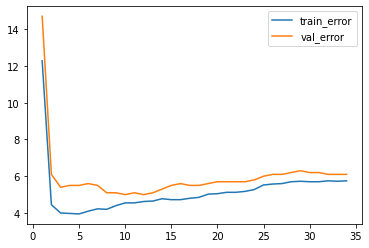

In [21]:
# plot the training and validation error rate vs. the thresholds
# choose the threshold with the minimal validation error rate and report the corresponding test error rate

plt.plot(thresholds, train_error)
plt.plot(thresholds, val_error)
plt.legend(['train_error', 'val_error'])
# choose my opt
opt = np.argmin(val_error) ## correction: should be opt = opt + 1. 
print('Best performance at validated threshold {} with test error rate {}.'.format(opt, test_error[opt]))

the above threshold should be T = 10 = 9 + 1. I just found this error after I ran these codes on my friends computer(which is more advanced and runs much faster), and there is no time to start again on my computer. Thank you for your comprehension.